In [1]:
set.seed(2020)
library(readr)
library(lubridate)
library(ggplot2)
library(dplyr)
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)

players <- read.csv("players.csv")
sessions <- read.csv("sessions.csv")

cat("Players dataset:", nrow(players), "rows,", ncol(players), "columns\n")
cat("Sessions dataset:", nrow(sessions), "rows,", ncol(sessions), "columns\n")

head(players)
head(sessions)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.0     ✔ tibble  3.2.1
✔ purrr   1.0.2     ✔ tidyr   1.3.1
✔ stringr 1.5.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4

Players dataset: 196 rows, 7 columns
Sessions dataset: 1535 rows, 5 columns


,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


,hashedEmail,start_time,end_time,original_start_time,original_end_time
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
2,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
3,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
4,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
5,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
6,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


| Dataset        | Observations | Variables | Description                                                     |
| -------------- | ------------ | --------- | --------------------------------------------------------------- |
| `players.csv`  | 196          | 7         | Contains demographic and experience information for each player |
| `sessions.csv` | 1535         | 5         | Contains detailed time records of each player’s gaming sessions |

| Variable       | Type      | Description                                                                  |
| -------------- | --------- | ---------------------------------------------------------------------------- |
| `experience`   | Character | The player’s experience level (e.g., *Amateur*, *Regular*, *Pro*, *Veteran*) |
| `subscribe`    | Logical   | Whether the player has an active subscription (TRUE/FALSE)                   |
| `hashedEmail`  | Character | Anonymized unique identifier for each player, used to link across datasets   |
| `played_hours` | Numeric   | Total hours the player has played so far                                     |
| `name`         | Character | Player’s in-game name                                                        |
| `gender`       | Character | Player’s gender (*Male* or *Female*)                                         |
| `Age`          | Integer   | Player’s age (in years)                                                      |

| Variable              | Type      | Description                                                     |
| --------------------- | --------- | --------------------------------------------------------------- |
| `hashedEmail`         | Character | Both data has that as a unique identifier   |
| `start_time`          | Character | The start time of the game session |
| `end_time`            | Character | The end time of the game session                                |
| `original_start_time` | Numeric   | Unix-style timestamp representing the start of the session      |
| `original_end_time`   | Numeric   | Unix-style timestamp representing the end of the session        |

**Introduction** \
This project investigates the question: how will we use factors like age and whether the player subscribes to a gaming newsletter to predict the hours played by a player. And to determine the type of player that would contribute a lot of data. To answer this, we will use data analysis and a K-Nearest Neighbors (KNN) regression model to examine the relationship between player's traits and total recorded playtime.

In [2]:
players<-read_csv("https://raw.githubusercontent.com/danayong25-cell/Group-Final-Project/refs/heads/main/players.csv")

sessions<-read_csv("https://raw.githubusercontent.com/danayong25-cell/Group-Final-Project/refs/heads/main/sessions.csv")|>
    separate(start_time,into=c("start_date","start_time"),sep=" ")|>
    separate(end_time,into=c("end_date","end_time"),sep=" ")|>
        mutate(
            start_dt = as.POSIXct(paste(start_date,start_time),format="%d/%m/%Y %H:%M"),
            end_dt = as.POSIXct(paste(end_date,end_time),format="%d/%m/%Y %H:%M"),
            duration_hours= as.numeric(difftime(end_dt,start_dt,units="hours"))
        )
head(sessions)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_date,start_time,end_date,end_time,original_start_time,original_end_time,start_dt,end_dt,duration_hours
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024,18:12,30/06/2024,18:24,1.71977e+12,1.71977e+12,2024-06-30 18:12:00,2024-06-30 18:24:00,0.2000000
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024,23:33,17/06/2024,23:46,1.71867e+12,1.71867e+12,2024-06-17 23:33:00,2024-06-17 23:46:00,0.2166667
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024,17:34,25/07/2024,17:57,1.72193e+12,1.72193e+12,2024-07-25 17:34:00,2024-07-25 17:57:00,0.3833333
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024,03:22,25/07/2024,03:58,1.72188e+12,1.72188e+12,2024-07-25 03:22:00,2024-07-25 03:58:00,0.6000000
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024,16:01,25/05/2024,16:12,1.71665e+12,1.71665e+12,2024-05-25 16:01:00,2024-05-25 16:12:00,0.1833333
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024,15:08,23/06/2024,17:10,1.71916e+12,1.71916e+12,2024-06-23 15:08:00,2024-06-23 17:10:00,2.0333333


In [3]:
player_sessions<-sessions|>
    group_by(hashedEmail) |>
    summarise(
    total_hours = sum(duration_hours, na.rm = TRUE),
    session_count = n()
    )
player_sessions|>
    summarise(across(where(is.numeric), ~ round(mean(.x, na.rm = TRUE), 2)))

total_hours,session_count
<dbl>,<dbl>
10.4,12.28


In [4]:
full_data<-players|>
    left_join(player_sessions,by="hashedEmail")
head(full_data)

experience,subscribe,hashedEmail,played_hours,name,gender,Age,total_hours,session_count
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,33.65000000,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,4.25000000,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,0.08333333,1
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,0.83333333,1
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,0.15000000,1
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


In [5]:
summary(sessions$duration_hours)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0500  0.1500  0.5000  0.8476  1.2167  4.3167       2 

In [6]:
players|>
    summarise(across(where(is.numeric), ~ round(mean(.x, na.rm = TRUE), 2)))

played_hours,Age
<dbl>,<dbl>
5.85,21.14


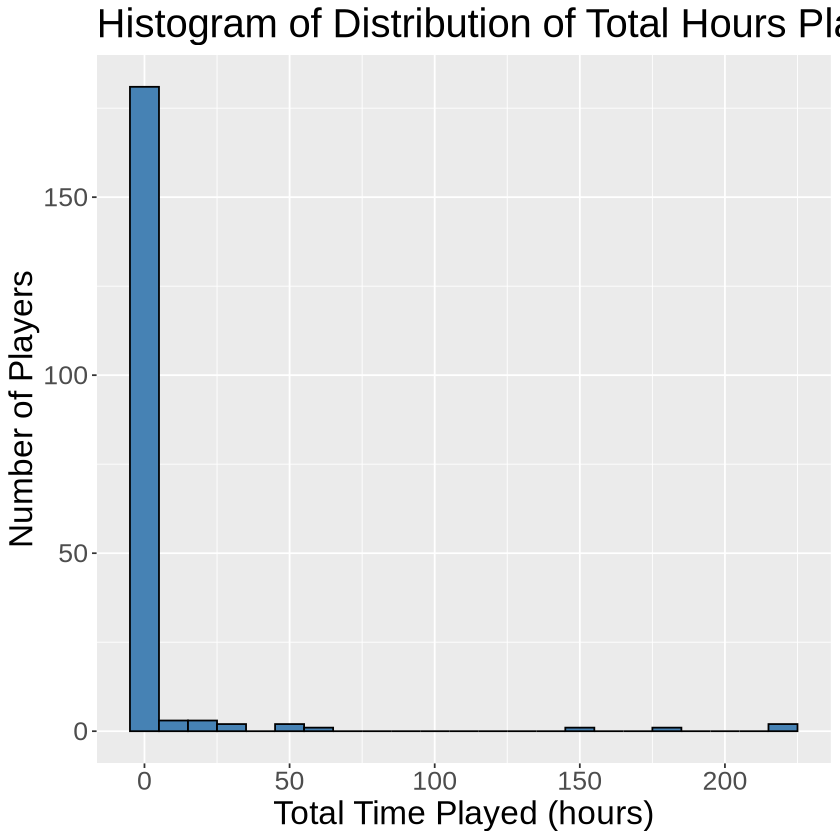

In [7]:
total_hours_histogram<-ggplot(full_data |> filter(!is.na(played_hours)), aes(x = played_hours)) +
    geom_histogram(binwidth = 10, fill = "steelblue", color = "black") +
    labs(title = "Histogram of Distribution of Total Hours Played",
         x = "Total Time Played (hours)",
         y = "Number of Players")+
    theme(text=element_text(size=20))
total_hours_histogram

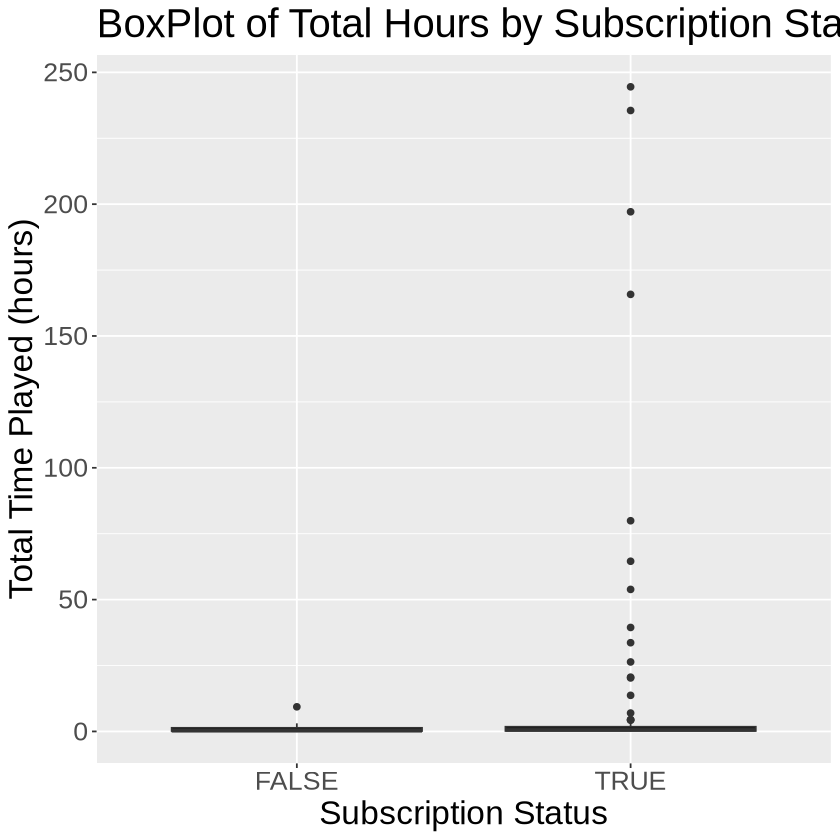

In [8]:
total_hours_boxplot <- ggplot(full_data |> filter(!is.na(total_hours)), aes(x = subscribe, y = total_hours)) +
    geom_boxplot(fill = "black") +
    labs(title = "BoxPlot of Total Hours by Subscription Status",
         x = "Subscription Status",
         y = "Total Time Played (hours)")+
    theme(text=element_text(size=20))
total_hours_boxplot

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”


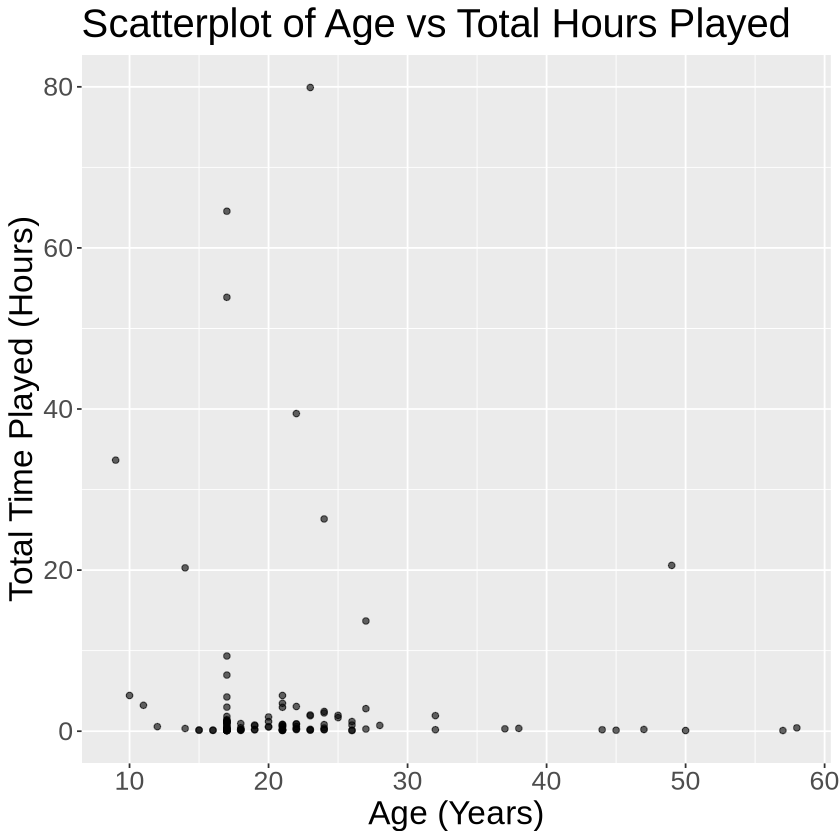

In [9]:
total_hours_scatterplot<-ggplot(full_data |> filter(!is.na(total_hours)), aes(x = Age, y = total_hours)) +
  geom_point(alpha = 0.6, color = "black") +
  labs(title = "Scatterplot of Age vs Total Hours Played",
       x = "Age (Years)",
       y = "Total Time Played (Hours)")+
    ylim(c(0,80))+
    theme(text=element_text(size=20))
total_hours_scatterplot

In [19]:
full_data$subscribe<-factor(full_data$subscribe,levels=c("true","false"))

split <- initial_split(full_data, prop = 0.75, strata = total_hours)
data_training <- training(split)
data_testing <- testing(split)

data5fold <- vfold_cv(data_training, v=5)
kvals <- tibble(neighbors = 1:20)

knn_spec<- nearest_neighbor(mode="regression",neighbors = tune()) |>
   set_engine("kknn")

knn_recipe <- recipe(total_hours ~ Age + subscribe, data = data_training) |>
    step_unknown(all_nominal_predictors(),new_level="missing")|>
    step_dummy(all_nominal_predictors())|>
    step_zv(all_predictors())|>
    step_normalize(all_numeric_predictors())

knn_workflow<-workflow()|>
    add_model(knn_spec) |>
    add_recipe(knn_recipe)
knn_workflow

knn_tuned<-tune_grid(knn_workflow,resamples=data5fold,grid=kvals,metrics=metric_set(rmse))
collect_metrics(knn_tuned)

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
4 Recipe Steps

• step_unknown()
• step_dummy()
• step_zv()
• step_normalize()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,24.52795,5,10.413200,Preprocessor1_Model01
2,rmse,standard,25.39811,5,10.156854,Preprocessor1_Model02
3,rmse,standard,30.33852,5,9.473027,Preprocessor1_Model03
4,rmse,standard,27.18278,5,9.880531,Preprocessor1_Model04
5,rmse,standard,27.40083,5,9.930615,Preprocessor1_Model05
6,rmse,standard,25.50243,5,10.291292,Preprocessor1_Model06
7,rmse,standard,24.93572,5,10.427722,Preprocessor1_Model07
8,rmse,standard,24.95915,5,10.416686,Preprocessor1_Model08
9,rmse,standard,24.36892,5,10.571600,Preprocessor1_Model09
